<a href="https://colab.research.google.com/github/mingoias/Sistema-de-cadastro-de-produtos-para-17-11/blob/main/Sistema_de_cadastro_de_produtos_para_17_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Database 'estoque.db' removed for a clean start.
Journal file 'estoque.db-journal' removed.

=== SISTEMA DE GESTÃO DE ESTOQUE ===
1 - Cadastrar item
2 - Listar itens
3 - Buscar item
4 - Movimentar Estoque (Entrada/Saída)
5 - Excluir item
6 - Relatórios e Gráficos
0 - Sair
Escolha: 1

=== Cadastrar Novo Item ===
Nome do item: maça
Categoria do item: alimento
Unidade ex: un, kg, L, cx, etc: kg
Quantidade inicial em Estoque: 30
Valor Unitário: 2
Item 'maça' cadastrado com sucesso!

=== SISTEMA DE GESTÃO DE ESTOQUE ===
1 - Cadastrar item
2 - Listar itens
3 - Buscar item
4 - Movimentar Estoque (Entrada/Saída)
5 - Excluir item
6 - Relatórios e Gráficos
0 - Sair
Escolha: laranja
Opção inválida.

=== SISTEMA DE GESTÃO DE ESTOQUE ===
1 - Cadastrar item
2 - Listar itens
3 - Buscar item
4 - Movimentar Estoque (Entrada/Saída)
5 - Excluir item
6 - Relatórios e Gráficos
0 - Sair
Escolha: 1

=== Cadastrar Novo Item ===
Nome do item: laranja
Categoria do item: alimento
Unidade ex: un, kg, L, cx, etc: 

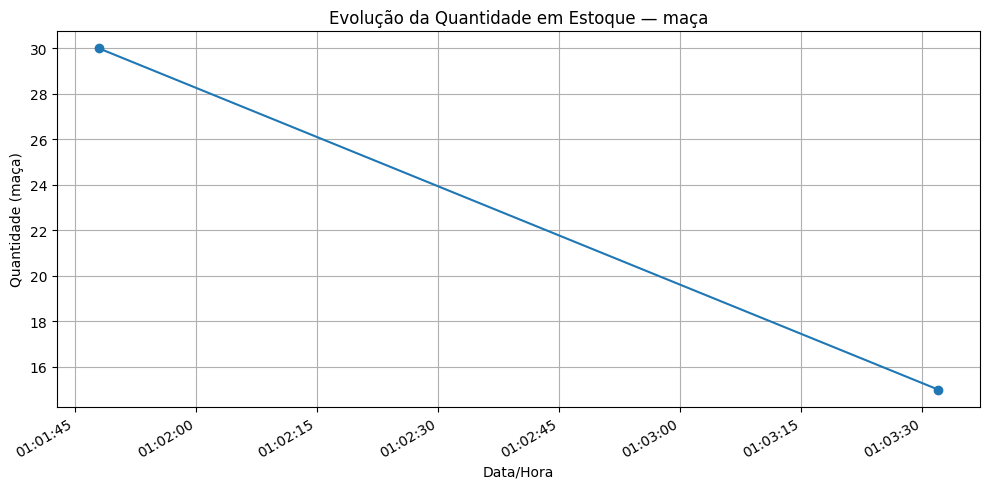


Selecione o gráfico desejado:
1 - Evolução do Valor Total do Estoque (Linha)
2 - Valor Total por Categoria (Barras)
3 - Curva ABC de Custo de Estoque (Pareto)
4. - Evolução da Quantidade (Item Específico)
0 - Voltar ao Menu Principal


In [ ]:
import sqlite3
#conexão com o módulo datetime(data e hora em tempo real)
from datetime import datetime
import os # Importar o módulo 'os' para operações de arquivo

#formação data/hora
DATE_FMT = "%Y-%m-%d %H:%M:%S"
#tenta importar a biblioteca matplot, e evita o erro caso não esteja instalada
try:
    import matplotlib.pyplot as plt
except ImportError:
    plt = None


DB_PATH = "estoque.db"

# Adicionado para garantir um estado limpo em ambientes interativos como o Colab
if os.path.exists(DB_PATH):
    os.remove(DB_PATH)
    print(f"Database '{DB_PATH}' removed for a clean start.")
if os.path.exists(DB_PATH + '-journal'):
    os.remove(DB_PATH + '-journal')
    print(f"Journal file '{DB_PATH}-journal' removed.")

#retorna a conexão com o banco de dados
def get_conn():
    # Habilita o suporte a chaves estrangeiras, necessário para ON DELETE CASCADE
    conn = sqlite3.connect(DB_PATH)
    conn.execute("PRAGMA foreign_keys = ON;")
    return conn


#define a função que executa o banco de dados
def create_db():
    conn = get_conn()
    cur = conn.cursor()
    cur.execute("""
    CREATE TABLE IF NOT EXISTS items (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        nome TEXT NOT NULL,
        categoria TEXT NOT NULL,
        unidade TEXT NOT NULL,
        quantidade REAL NOT NULL DEFAULT 0.0,
        valor_unitario REAL NOT NULL DEFAULT 0.0
    );
    """)
    cur.execute("""
    CREATE TABLE IF NOT EXISTS movimentos (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        item_id INTEGER NOT NULL,
        tipo TEXT NOT NULL,
        quantidade REAL NOT NULL,
        valor_unitario REAL NOT NULL,
        datahora TEXT NOT NULL,
        estoque_qtd_após REAL NOT NULL,
        total_estoque_após REAL NOT NULL,
        FOREIGN KEY (item_id) REFERENCES items(id)
    );
    """)
    conn.commit()
    conn.close()


#função que calcula valor total em estoque
def calcular_total_estoque(conn):
    cur = conn.cursor()
    cur.execute("SELECT quantidade, valor_unitario FROM items;")
    total = 0.0
    for qtd, vu in cur.fetchall():
        total += (qtd or 0.0) * (vu or 0.0)
    return total


#função de valor flutuante
def input_float(prompt, minimo=None):
    while True:
        val = input(prompt).replace(",", ".").strip()
        try:
            x = float(val)
            if minimo is not None and x < minimo:
                print(f"Valor deve ser >= {minimo}.")
                continue
            return x
        except ValueError:
            print("Entrada inválida. Digite um número.")


def print_item_row(row):
    _id, nome, cat, un, qtd, vu = row
    total = (qtd or 0.0) * (vu or 0.0)
    print(f"[{_id}] {nome} | Cat: {cat} | Un: {un} | Qtd: {qtd:.3f} | VU: R$ {vu:,.2f} | Total Item: R$ {total:,.2f}")


#cria uma função que seleciona itens
def selecionar_item(conn):
    cur = conn.cursor()
    cur.execute("SELECT id, nome FROM items ORDER BY id;")
    rows = cur.fetchall()
    if not rows:
        print("Não há itens cadastrados.")
        return None
    print("\nSelecione o item pelo ID:")
    for _id, nome in rows:
        print(f"[{_id}] {nome}")
    while True:
        try:
            alvo = int(input("ID do item: ").strip())
            cur.execute("SELECT id FROM items WHERE id = ?;", (alvo,))
            if cur.fetchone():
                return alvo
            print("ID inválido.")
        except ValueError:
            print("Digite um número inteiro para o ID.")



#cria uma função que cadastra itens
def cadastrar_item():
    print("\n=== Cadastrar Novo Item ===")
    nome = input("Nome do item: ").strip()
    categoria = input("Categoria do item: ").strip()
    unidade = input("Unidade ex: un, kg, L, cx, etc: ").strip()
    quantidade = input_float("Quantidade inicial em Estoque: ", minimo=0.0)
    valor_unitario = input_float("Valor Unitário: ", minimo=0.0)

    if not nome or not categoria or not unidade:
        print("Erro: Nome, Categoria e Unidade não podem estar vazios.")
        return

    conn = get_conn()
    cur = conn.cursor()
    cur.execute("""
        INSERT INTO items (nome, categoria, unidade, quantidade, valor_unitario)
        VALUES (?, ?, ?, ?, ?);
    """, (nome, categoria, unidade, quantidade, valor_unitario))

    item_id = cur.lastrowid
    now = datetime.now().strftime(DATE_FMT)
    total_estoque = calcular_total_estoque(conn)

    cur.execute("""
        INSERT INTO movimentos (item_id, tipo, quantidade, valor_unitario, datahora, estoque_qtd_após, total_estoque_após)
        VALUES (?, 'init', ?, ?, ?, ?, ?);
    """, (item_id, quantidade, valor_unitario, now, quantidade, total_estoque))

    conn.commit()
    conn.close()
    print(f"Item '{nome}' cadastrado com sucesso!")


def listar_itens():
    print("\n=== Itens Cadastrados ===")
    conn = get_conn()
    cur = conn.cursor()
    cur.execute("SELECT id, nome, categoria, unidade, quantidade, valor_unitario FROM items ORDER BY nome;")
    rows = cur.fetchall()
    conn.close()
    if not rows:
        print("Nenhum item cadastrado.")
        return
    for r in rows:
        print_item_row(r)


def buscar_itens():
    print("\n=== Buscar Itens ===")
    termo = input("Buscar por (nome ou categoria, contém): ").strip()
    conn = get_conn()
    cur = conn.cursor()
    cur.execute("""
        SELECT id, nome, categoria, unidade, quantidade, valor_unitario
        FROM items
        WHERE nome LIKE ? OR categoria LIKE ?
        ORDER BY nome;
    """, (f"%{termo}%", f"%{termo}%"))
    rows = cur.fetchall()
    conn.close()
    if not rows:
        print("Nenhum item encontrado.")
        return
    for r in rows:
        print_item_row(r)


#função que atualiza o estoque (Entrada/Saída)
def atualizar_item():
    print("\n=== Movimentar Estoque (Entrada/Saída) ===")
    conn = get_conn()
    try:
        item_id = selecionar_item(conn)
        if item_id is None:
            return # A conexão será fechada no 'finally'

        tipo = ""
        while tipo not in ("E", "S"):
            tipo = input("Tipo (E = Entrada | S = Saída): ").strip().upper()

        qtd_mov = input_float("Quantidade da movimentação: ", minimo=0.0)

        cur = conn.cursor()
        cur.execute("SELECT quantidade, valor_unitario FROM items WHERE id = ?;", (item_id,))
        row = cur.fetchone()

        if not row:
            print("Item não encontrado.")
            return

        qtd_atual, vu_atual = row

        if tipo == "E":
            nova_qtd = qtd_atual + qtd_mov
            mov_tipo = "entrada"
        else: # tipo == "S"
            if qtd_mov > qtd_atual:
                print(f"Erro: saída ({qtd_mov}) maior que o estoque atual ({qtd_atual}). Operação cancelada.")
                return
            nova_qtd = qtd_atual - qtd_mov
            mov_tipo = "saida"

        cur.execute("""
            UPDATE items
            SET quantidade = ?
            WHERE id = ?;
        """, (nova_qtd, item_id))

        total_estoque_após = calcular_total_estoque(conn)
        now = datetime.now().strftime(DATE_FMT)

        cur.execute("""
            INSERT INTO movimentos (item_id, tipo, quantidade, valor_unitario, datahora, estoque_qtd_após, total_estoque_após)
            VALUES (?, ?, ?, ?, ?, ?, ?);
        """, (item_id, mov_tipo, qtd_mov, vu_atual, now, nova_qtd, total_estoque_após))

        conn.commit()
        print("Movimentação registrada com sucesso!")

    finally:
        if conn:
            conn.close()

def excluir_item():
    print("\n=== Excluir Item ===")
    conn = get_conn()
    try:
        item_id = selecionar_item(conn)
        if item_id is None:
            return
        # Confirmação de exclusão
        cur = conn.cursor()
        cur.execute("SELECT nome FROM items WHERE id = ?;", (item_id,))
        nome_item = cur.fetchone()[0]

        confirm = input(f"Tem certeza que deseja excluir o item '{nome_item}' (ID: {item_id})? \n"
                        "TODOS os seus movimentos de estoque também serão apagados. (s/n): ").strip().lower()

        if confirm == 's':
            cur.execute("DELETE FROM items WHERE id = ?;", (item_id,))
            conn.commit()
            print(f"Item '{nome_item}' e seu histórico foram excluídos com sucesso.")
        else:
            print("Exclusão cancelada.")

    except Exception as e:
        print(f"Ocorreu um erro ao excluir: {e}")
        if conn:
            conn.rollback() # Desfaz a operação em caso de erro
    finally:
        if conn:
            conn.close()


def grafico():
    print("\n=== Módulo de Gráficos ===")
    if plt is None:
        print("O módulo matplotlib não está instalado. Instale com: pip install matplotlib")
        return

    conn = get_conn() # Abre a conexão uma vez
    try:
        while True:
            print("\nSelecione o gráfico desejado:")
            print("1 - Evolução do Valor Total do Estoque (Linha)")
            print("2 - Valor Total por Categoria (Barras)")
            print("3 - Curva ABC de Custo de Estoque (Pareto)")
            print("4. - Evolução da Quantidade (Item Específico)")
            print("0 - Voltar ao Menu Principal")

            opcao = input("Escolha: ").strip()

            if opcao == "1":
                grafico_evolucao_valor(conn)
            elif opcao == "2":
                grafico_barras_categoria(conn)
            elif opcao == "3":
                grafico_curva_abc(conn)
            elif opcao == "4":
                grafico_evolucao_item(conn)
            elif opcao == "0":
                break
            else:
                print("Opção inválida.")

    finally:
        if conn:
            conn.close() # Fecha a conexão ao sair do módulo de gráficos


def grafico_evolucao_valor(conn):
    print("Gerando: Gráfico de Evolução do Valor Total...")
    cur = conn.cursor()
    cur.execute("""
        SELECT datahora, total_estoque_após
        FROM movimentos
        ORDER BY datetime(datahora);
    """)
    movs = cur.fetchall()

    if not movs:
        print("Sem movimentações para exibir.")
        return

    # Tenta converter datas, pulando formatos inválidos
    datas_total = []
    valores_total = []
    for d, v in movs:
        try:
            datas_total.append(datetime.strptime(d, DATE_FMT))
            valores_total.append(v)
        except ValueError:
            print(f"Aviso: Pulando data com formato inválido: {d}")

    if not datas_total:
        print("Nenhum dado válido para plotar.")
        return

    plt.figure(figsize=(10, 5))
    plt.plot(datas_total, valores_total, marker='o', linestyle='-')
    plt.xlabel("Data/Hora")
    plt.ylabel("Valor total do estoque (R$)")
    plt.title("Evolução do Valor Total do Estoque")
    plt.gcf().autofmt_xdate() # Formata data
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def grafico_barras_categoria(conn):
    print("Gerando: Gráfico de Valor por Categoria...")
    cur = conn.cursor()
    cur.execute("""
        SELECT categoria, SUM(quantidade * valor_unitario) as valor_total
        FROM items
        GROUP BY categoria
        HAVING valor_total > 0
        ORDER BY valor_total DESC;
    """)
    rows = cur.fetchall()

    if not rows:
        print("Nenhum item com valor em estoque para agrupar por categoria.")
        return

    categorias = [r[0] for r in rows]
    valores = [r[1] for r in rows]



    plt.figure(figsize=(10, 5))
    bars = plt.bar(categorias, valores)
    plt.xlabel("Categoria")
    plt.ylabel("Valor Total em Estoque (R$)")
    plt.title("Valor Total de Estoque por Categoria")

    # Adiciona rótulos de valor em cima das barras
    plt.bar_label(bars, fmt='R$ {:,.2f}')

    plt.tight_layout()
    plt.show()


def grafico_curva_abc(conn):
    print("Gerando: Curva ABC de Custo de Estoque...")
    cur = conn.cursor()
    cur.execute("""
        SELECT nome, (quantidade * valor_unitario) as valor_total
        FROM items
        WHERE (quantidade * valor_unitario) > 0
        ORDER BY valor_total DESC;
    """)
    rows = cur.fetchall()

    if not rows:
        print("Nenhum item com valor em estoque para calcular a curva ABC.")
        return

    nomes = [r[0] for r in rows]
    valores = [r[1] for r in rows]

    total_geral = sum(valores)

    # Calcula porcentagem acumulada
    valores_acumulados = []
    acumulado = 0.0
    for v in valores:
        acumulado += v
        valores_acumulados.append((acumulado / total_geral) * 100)



    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Eixo 1: Barras com valores individuais
    ax1.set_title('Curva ABC de Valor de Estoque (Pareto)')
    ax1.set_xlabel('Itens (ordenados por valor)')
    ax1.set_ylabel('Valor Individual (R$)', color='blue')
    ax1.bar(nomes, valores, color='blue', alpha=0.7)
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.xticks(rotation=90) # Gira o nome dos itens

    # Eixo 2: Linha com porcentagem acumulada
    ax2 = ax1.twinx() # Compartilha o mesmo eixo X
    ax2.set_ylabel('Valor Acumulado (%)', color='red')
    ax2.plot(nomes, valores_acumulados, color='red', marker='o', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='red')

    # Linhas de classificação A (80%) e B (95%)
    ax2.axhline(80, color='red', linestyle=':', linewidth=2, label='Classe A (80%)')
    ax2.axhline(95, color='orange', linestyle=':', linewidth=2, label='Classe B (95%)')
    ax2.set_ylim(0, 105)
    ax2.legend(loc='center right')

    fig.tight_layout()
    plt.show()


def grafico_evolucao_item(conn):
    print("\n--- Evolução de Item Específico ---")
    item_id = selecionar_item(conn)
    if item_id is None:
        return

    cur = conn.cursor()
    cur.execute("SELECT nome FROM items WHERE id = ?;", (item_id,))
    nome_item = cur.fetchone()
    nome_item = nome_item[0] if nome_item else f"Item {item_id}"

    cur.execute("""
        SELECT datahora, estoque_qtd_após
        FROM movimentos
        WHERE item_id = ?
        ORDER BY datetime(datahora);
    """, (item_id,))
    serie = cur.fetchall()

    if not serie:
        print("Este item não possui movimentações registradas.")
        return

    # Tenta converter datas
    datas_item = []
    qtds_item = []
    for d, q in serie:
        try:
            datas_item.append(datetime.strptime(d, DATE_FMT))
            qtds_item.append(q)
        except ValueError:
            print(f"Aviso: Pulando data com formato inválido: {d}")

    if not datas_item:
        print("Nenhum dado válido para plotar.")
        return

    plt.figure(figsize=(10, 5))
    plt.plot(datas_item, qtds_item, marker='o')
    plt.xlabel("Data/Hora")
    plt.ylabel(f"Quantidade ({nome_item})")
    plt.title(f"Evolução da Quantidade em Estoque — {nome_item}")
    plt.gcf().autofmt_xdate()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def menu():
    create_db()
    while True:
        print("\n=== SISTEMA DE GESTÃO DE ESTOQUE ===")
        print("1 - Cadastrar item")
        print("2 - Listar itens")
        print("3 - Buscar item")
        print("4 - Movimentar Estoque (Entrada/Saída)")
        print("5 - Excluir item")
        print("6 - Relatórios e Gráficos")
        print("0 - Sair")

        opcao = input("Escolha: ").strip()

        if opcao == "1":
            cadastrar_item()
        elif opcao == "2":
            listar_itens()
        elif opcao == "3":
            buscar_itens()
        elif opcao == "4":
            atualizar_item()
        elif opcao == "5":
            excluir_item()
        elif opcao == "6":
            grafico()
        elif opcao == "0":
            print("Encerrando operação!")
            break
        else:
            print("Opção inválida.")

if __name__ == "__main__":
    create_db()
    menu()